# Generating synthetic lightcurves and fitting the power spectral density of a lightcurve #

This notebook presents the advanced Emmanoulopoulos algorithm for the simulation of synthetic lightcurves. The original paper describing the algorithm is linked [here](https://arxiv.org/pdf/1305.0304.pdf). The version implemented here is compatible with the Gammapy implementation of the Timmer-Koenig algorithm.
The Timmer-Koenig algorithm generates synthetic lightcurve from a chosen power spectral density (PSD) shape. However, it can only generate time series with a gaussian probability density function (PDF). This is adequate for high-statistics astrophysical domains such as the optical or X-rays, but can be in issue when trying to reproduce curves in the gamma-ray domain, where photon counts are lower and statistics are generally Poissonian. The Emmanoulopoulos algorithm tries to solve this issue, combining a requested PSD and PDF in the simulation. It provides accurate synthetic lightcurves in a range of spectral indexes between -1 and -2 for power-law or similar PSDs.

Together with the simulation algorithm the notebook adds a function to compute the PSD envelope for a lightcurve using either the Timmer-Koenig or the Emmanoulopoulos algorithm. This envelope is then used to fit the PSD fot he observed lightcurve, by passing through a tailored chi-squared-like cost function. This complex fitting is necessary to account for the fact that the periodogram of the observed lightcurve is only a possible realization of the PSD model, moreover convoluted with Poissonian noise and instrumental responses. This can lead to biases or deformation due to random fluctuation of the realization if extracted with a simple curve fit of the periodogram.

The results are satisfactory for power-law or broken-power-law PSDs in a physical interval of spectral indexes, between -1 and -2. Using the Emmanoulopoulos algorithm shows consistently better PSD reconstruction over the Timmer-Koenig - this is due to the injected non-gaussian PDF.

## Imports ##

The first step is importing some usual packages, needed Astropy utilities, scipy tools for PDFs and minimization, and Gammapy functions and classes for the observational part.

In [13]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import inspect

import astropy.units as u
from astropy.coordinates import SkyCoord, AltAz

from regions import PointSkyRegion

from gammapy.estimators import LightCurveEstimator, FluxPoints
from gammapy.makers import SpectrumDatasetMaker
from gammapy.data import Observation, observatory_locations, FixedPointingInfo
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.irf import load_irf_dict_from_file
from gammapy.maps import MapAxis, RegionGeom, TimeMapAxis, RegionNDMap
from gammapy.modeling.models import SkyModel, PowerLawSpectralModel, LightCurveTemplateTemporalModel
from gammapy.estimators.utils import compute_lightcurve_fvar
from gammapy.utils.random import get_random_state

from scipy.optimize import minimize
from scipy.signal import periodogram
from scipy.stats import lognorm

## Reference Lightcurve ##

As a reference, the notebook uses the H.E.S.S. dataset for the PKS2155 AGN flare of 2006. Data properties such as mean and standard deviation fo the norm, number of points, sampling frequency, are taken from this flare. The synthetic lightcurve will be oversampled by a factor 10.

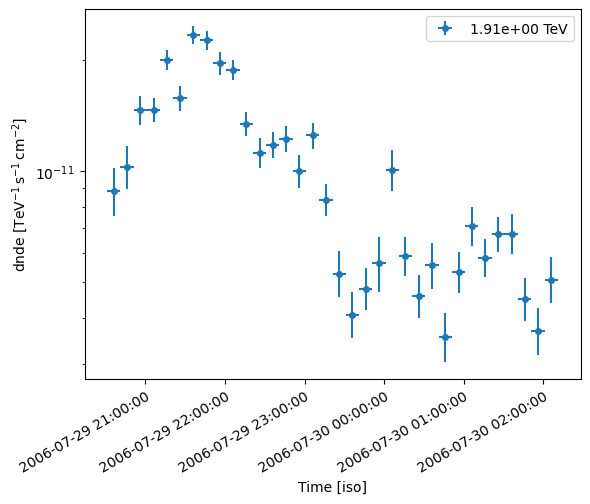

In [14]:
lc_path = Path("$GAMMAPY_DATA/estimators/")
lc_filename = "pks2155_hess_lc/pks2155_hess_lc.fits"

lc = FluxPoints.read(lc_path/lc_filename, format="lightcurve")
odata = lc.norm.data.flatten()
omean = odata.mean()
ostd = odata.std()
npoints = len(lc.norm.data)*10
times = lc.geom.axes["time"].edges
tref = lc.geom.axes["time"].reference_time
smax = np.diff(times).max()/10
lc.plot()
plt.show()

## Function definition ##

Some simple function definitions for PSD and PDF models, with their default parameters.

In [15]:
def emm_gammalognorm(x, wgamma, a, s, loc, scale):
    return wgamma*gamma.pdf(x, a) + (1-wgamma)*lognorm.pdf(x, s, loc, scale)

In [16]:
def bpl(x, norm, aup, adn, x0):
    return norm*(x**(-adn))/(1+((x/x0)**(aup-adn)))

In [17]:
def pl(x, index):
    return x**index

In [18]:
bpl_params = {"norm":1, "aup":2.4, "adn":3, "x0":0.1}
gl_params = {"wgamma":0.82,"a":5.67, "s":0.31, "loc":2.14, "scale":1}
ln_params = {'s': 0.5, 'loc': 1.5, 'scale': 1}
pl_params = {"index": -1.4}

## The Emmanoulopoulos algorithm ##

The algorithm requires a PDF and PSD shape, the number of points to simulate and spacing between the points (as an astropy Quantity). Optionally can be passed: parameters for the PSD and PDF, random state for reproducibility, maximum number of iterations for the internal loop, number of chunk factor by which the length is multiplicated to avoid red noise leakage, target mean and standard deviation of the time series, whether to add poissonian noise internally to simulate observational effects.

In [19]:
def TimmerKonig_lightcurve_simulator(
    power_spectrum,
    npoints,
    spacing,
    nchunks=10,
    random_state="random-seed",
    power_spectrum_params=None,
    mean=0.0,
    std=1.0,
    poisson=False,
):

    if not callable(power_spectrum):
        raise ValueError(
            "The power spectrum has to be provided as a callable function."
        )

    if not isinstance(npoints * nchunks, int):
        raise TypeError("npoints and nchunks must be integers")

    if poisson:
        if isinstance(mean, u.Quantity):
            wmean = mean.value * spacing.value
        else:
            wmean = mean * spacing.value
        if wmean < 1.0:
            raise Warning(
                "Poisson noise was requested but the target mean is too low - resulting counts will likely be 0."
            )

    random_state = get_random_state(random_state)

    npoints_ext = npoints * nchunks

    frequencies = np.fft.fftfreq(npoints_ext, spacing.value)

    # To obtain real data only the positive or negative part of the frequency is necessary.
    real_frequencies = np.sort(np.abs(frequencies[frequencies < 0]))

    if power_spectrum_params:
        periodogram = power_spectrum(real_frequencies, **power_spectrum_params)
    else:
        periodogram = power_spectrum(real_frequencies)

    real_part = random_state.normal(0, 1, len(periodogram) - 1)
    imaginary_part = random_state.normal(0, 1, len(periodogram) - 1)

    # Nyquist frequency component handling
    if npoints_ext % 2 == 0:
        idx0 = -2
        random_factor = random_state.normal(0, 1)
    else:
        idx0 = -1
        random_factor = random_state.normal(0, 1) + 1j * random_state.normal(0, 1)

    fourier_coeffs = np.concatenate(
        [
            np.sqrt(0.5 * periodogram[:-1]) * (real_part + 1j * imaginary_part),
            np.sqrt(0.5 * periodogram[-1:]) * random_factor,
        ]
    )
    fourier_coeffs = np.concatenate(
        [fourier_coeffs, np.conjugate(fourier_coeffs[idx0::-1])]
    )

    fourier_coeffs = np.insert(fourier_coeffs, 0, 0)
    time_series = np.fft.ifft(fourier_coeffs).real

    ndiv = npoints_ext // (2 * nchunks)
    setstart = npoints_ext // 2 - ndiv
    setend = npoints_ext // 2 + ndiv
    if npoints % 2 != 0:
        setend = setend + 1
    time_series = time_series[setstart:setend]

    time_series = (time_series - time_series.mean()) / time_series.std()
    time_series = time_series * std + mean

    if poisson:
        time_series = (
            random_state.poisson(
                np.where(time_series >= 0, time_series, 0) * spacing.value
            )
            / spacing.value
        )

    time_axis = np.linspace(0, npoints * spacing.value, npoints) * spacing.unit

    return time_series, time_axis


In [20]:
def Emmanoulopoulos_lightcurve_simulator(pdf, psd, npoints, spacing, pdf_params=None, psd_params=None, random_state="random-seed", imax = 1000, nchunks=10, mean=0.0, std=1.0, poisson=False):
    
    target_cps = 0.2
    lc_norm, taxis = TimmerKonig_lightcurve_simulator(psd, npoints, spacing, nchunks = nchunks, power_spectrum_params=psd_params, random_state=random_state)

    random_state = get_random_state(random_state)
    
    fft_norm = np.fft.rfft(lc_norm)

    a_norm = np.abs(fft_norm)/npoints
    phi_norm = np.angle(fft_norm)

    if "scale" in pdf_params: scale = pdf_params.get("scale")
    else: scale = 1
    
    xx = np.linspace(0, scale*10, 1000)
    lc_sim = np.interp(random_state.rand(npoints), np.cumsum(pdf(xx, **pdf_params))/np.sum(pdf(xx, **pdf_params)), xx)
    lc_sim = (lc_sim - lc_sim.mean())/lc_sim.std()

    nconv = True
    i=0
    while nconv and i<imax:
        i+=1
        fft_sim = np.fft.rfft(lc_sim)
        a_sim = np.abs(fft_sim)/npoints
        phi_sim = np.angle(fft_sim)
        fft_adj = a_norm * np.exp(1j * phi_sim)
        lc_adj = np.fft.irfft(fft_adj, npoints)
        if  np.array_equal(np.argsort(lc_sim),np.argsort(lc_adj)): nconv=False
        lc_adj[np.argsort(lc_adj)] = lc_sim[np.argsort(lc_sim)]
        lc_sim = lc_adj

    lc_sim = (lc_sim - lc_sim.mean()) / lc_sim.std()
    lc_sim = lc_sim * std + mean

    if poisson:
        
        lc_sim = (
            random_state.poisson(
                np.where(lc_sim >= 0, lc_sim, 0) * spacing.decompose().value*target_cps
            )
            / (spacing.decompose().value*target_cps)
        )
    
    return lc_sim, taxis

## Envelope and fitting ##

The envelope function returns a set of periodogram extracted from a number of simulations nsims that use the same parameters.

These envelopes can then be used via the x2_fit function to fit the requested PSD to an observed periodogram.

In [21]:
def lightcurve_psd_envelope(psd, npoints, spacing, pdf=None, nsims=10000, pdf_params=None, psd_params=None, simulator="TK", mean=0., std=1., oversample=10, poisson=False):
    npoints_ext = npoints*oversample
    spacing_ext = spacing/oversample
    if simulator== "TK" : tseries, taxis = TimmerKonig_lightcurve_simulator(psd, npoints_ext, spacing_ext, power_spectrum_params=psd_params, mean=mean, std=std, poisson=poisson)
    elif simulator== "EMM": tseries, taxis = Emmanoulopoulos_lightcurve_simulator(pdf, psd, npoints_ext, spacing_ext, pdf_params=pdf_params, psd_params=psd_params, mean=mean, std=std, poisson=poisson)
    freqs, pg = periodogram(tseries, 1/spacing_ext.value)
    envelopes_psd = np.empty((nsims, npoints//2))
    envelopes_psd[0] = pg[1:npoints//2+1]
    
    for _ in range(1, nsims):
        if simulator== "TK" : tseries, taxis = TimmerKonig_lightcurve_simulator(psd, npoints_ext, spacing_ext, power_spectrum_params=psd_params, mean=mean, std=std, poisson=poisson)
        else: tseries, taxis = Emmanoulopoulos_lightcurve_simulator(pdf, psd, npoints_ext, spacing_ext, pdf_params=pdf_params, psd_params=psd_params, mean=mean, std=std, poisson=poisson)

        freqs, pg = periodogram(tseries, 1/spacing_ext.value)
        envelopes_psd[_] = pg[1:npoints//2+1]

    return envelopes_psd, freqs[1:npoints//2+1]

In [22]:
def x2_fit(psd_params_list, pgram, npoints, spacing, psd, pdf=None, pdf_params=None, simulator="TK", nsims=10000, mean=None, std=None, poisson=False):

    psd_params_keys = list(inspect.signature(psd).parameters.keys())

    if len(psd_params_keys[1:]) != len(psd_params_list): raise ValueError("parameter values do not correspond to the request from the psd function")
    
    psd_params = dict(zip(psd_params_keys[1:], psd_params_list))
    
    envelopes, freqs = lightcurve_psd_envelope(psd, npoints, spacing, pdf=pdf, pdf_params=pdf_params, psd_params=psd_params, simulator=simulator, nsims=nsims, mean=mean, std=std, poisson=poisson)
    
    if len(envelopes[0])!= len(pgram): raise ValueError("required length is different than data length!")
    
    obs = (pgram - envelopes.mean(axis=0))**2/envelopes.std(axis=0)**2
    sim = (envelopes - envelopes.mean(axis=0))**2/envelopes.std(axis=0)**2
    sumobs = np.sum(obs)
    sumsim = np.sum(sim, axis=-1)
    sign = len(np.where(sumobs>=sumsim)[0])/nsims
    
    return sign

## Simulation ##

The simulation call for the algorithm. Both the TK and EMM algorithms are called with the same power-law PSD. The EMM algorithm uses a lognormal PDF. The difference between TK and EMM algorithms is shown in the leftmost and rightmost plot, where the gaussian vs lognormal shape is evident. The middle plot shows the perfect compatibility in the periodogram. Seed is fixed for reproducibility. 

[-1.47301407 -7.35992191] [-1.41604412 -6.92936994]
CPU times: user 45 ms, sys: 7.22 ms, total: 52.2 ms
Wall time: 57.5 ms


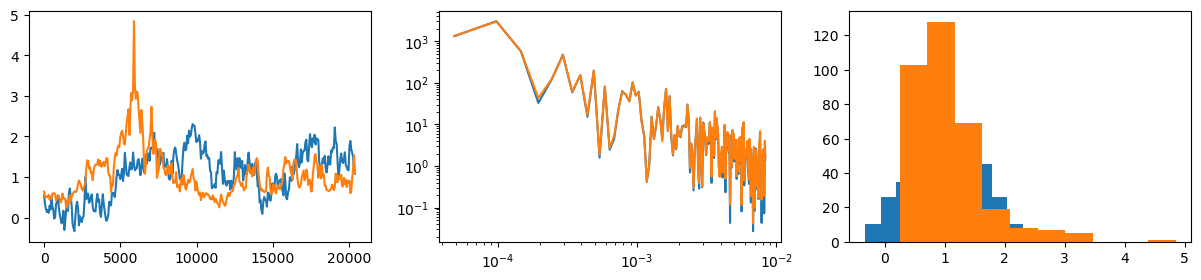

In [23]:
%%time
seed = 532019
#seed = "random-seed"
lctk2, taxis2 = Emmanoulopoulos_lightcurve_simulator(lognorm.pdf, pl, npoints, smax, pdf_params=ln_params, psd_params=pl_params,mean =omean, std=ostd,random_state=seed)
lctk, taxis = TimmerKonig_lightcurve_simulator(pl, npoints, smax, power_spectrum_params=pl_params,mean =omean, std=ostd,random_state=seed)
freqstk, pgramtk = periodogram(lctk, 1/smax.value)
freqstk2, pgramtk2 = periodogram(lctk2, 1/smax.value)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,3))
ax1.plot(taxis, lctk)
ax2.loglog(freqstk[1:], pgramtk[1:])
ax3.hist(lctk)
ax1.plot(taxis2, lctk2)
ax2.loglog(freqstk2[1:], pgramtk2[1:])
ax3.hist(lctk2)
coeff = np.polyfit(np.log(freqstk[1:]), np.log(pgramtk[1:]), 1)
coeff2 = np.polyfit(np.log(freqstk2[1:]), np.log(pgramtk2[1:]), 1)

print(coeff, coeff2)

## Gammapy setup and simulation ##

Setup of geometry for the Gammapy simulation. Generic setup for pointing, energy binning, and IRFs. For realistic simulations, choose IRFs that are consistent with the instrument and observational conditions.

In [24]:
TimeMapAxis.time_format = "iso"

path = Path("$GAMMAPY_DATA/cta-caldb")
irf_filename = "Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"

irfs = load_irf_dict_from_file(path / irf_filename)

energy_axis = MapAxis.from_energy_bounds(
    energy_min=0.1 * u.TeV, energy_max=100 * u.TeV, nbin=1
)

energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.2, 2.0, 31), unit="TeV", name="energy_true", interp="log"
)

time_axis = MapAxis.from_nodes(taxis, name="time", interp="lin")

geom = RegionGeom.create("galactic;circle(107.65, -40.17, 5)", axes=[energy_axis])

pointing_position = SkyCoord(107.65, -40.17, unit="deg", frame="galactic")
pointing = FixedPointingInfo(
    fixed_icrs=SkyCoord(107.65, -40.17, unit="deg", frame="galactic").icrs,
)

The time series generated via EMM is taken as a LightCurveTemplateTemporalModel

In [25]:
gti_t0 = tref

spectral_model = PowerLawSpectralModel(amplitude  = 1e-10 * u.TeV**-1 * u.cm**-2 * u.s**-1)

m = RegionNDMap.create(
    region=PointSkyRegion(center=pointing_position),
    axes=[time_axis],
    unit="cm-2s-1TeV-1",
)

m.quantity = lctk2

temporal_model = LightCurveTemplateTemporalModel(m, t_ref=gti_t0)

model_simu = SkyModel(
    spectral_model=spectral_model,
    temporal_model=temporal_model,
    name="model-simu",
)

Observation timing setup and simulation fo the datasets. The "observational" sampling is taken to be much sparser than the synthetic lightcurve, to avoid aliasing.

In [100]:
lvtm = 10 * u.min
tstart = gti_t0 + np.arange(npoints/10)*lvtm
altaz = pointing_position.transform_to(AltAz(obstime = tstart, location = observatory_locations["cta_south"]))

In [101]:
datasets = Datasets()

empty = SpectrumDataset.create(
geom=geom, energy_axis_true=energy_axis_true, name="empty"
)

maker = SpectrumDatasetMaker(selection=["exposure", "background", "edisp"])

for idx in range(len(tstart)):
    obs = Observation.create(
        pointing=pointing,
        livetime=lvtm,
        tstart=tstart[idx],
        irfs=irfs,
        reference_time=gti_t0,
        obs_id=idx,
        location=observatory_locations["cta_south"],
    )
    empty_i = empty.copy(name=f"dataset-{idx}")
    dataset = maker.run(empty_i, obs)
    dataset.models = model_simu
    dataset.fake()
    datasets.append(dataset)


spectral_model = PowerLawSpectralModel(amplitude  = 7e-11 * u.TeV**-1 * u.cm**-2 * u.s**-1)
model_fit = SkyModel(spectral_model=spectral_model, name="model-fit")
datasets.models = model_fit

Lightcurve estimator setup and run.

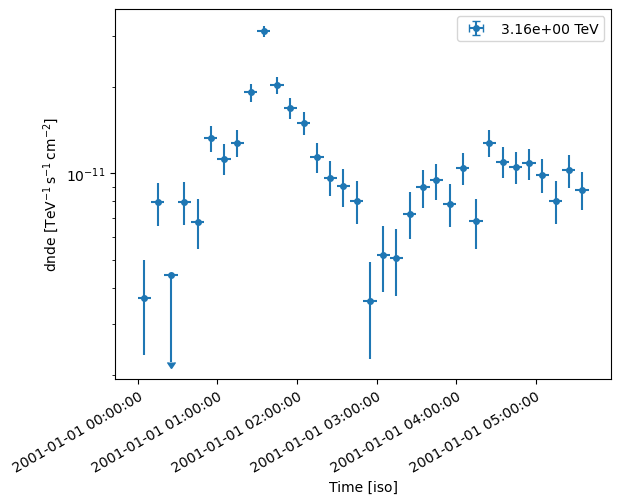

In [102]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.1, 100] * u.TeV,
    source="model-fit",
    selection_optional=["ul"],
)

lc_1d = lc_maker_1d.run(datasets)
lc_1d.plot();

Assessment of the properties of the "observed" lightcurve in the time and frequency domain.

-1.4034358347577256


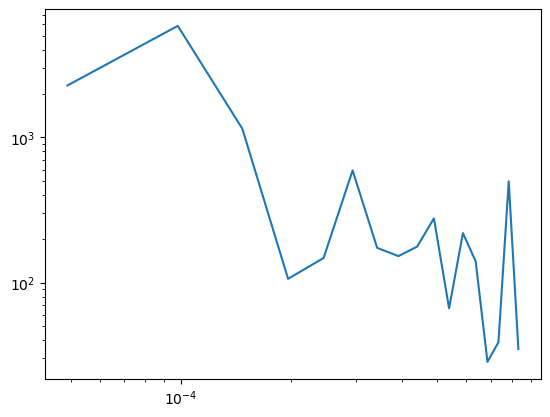

In [103]:
data = lc_1d.norm.data.flatten()
dmean = data.mean()
dstd = data.std()
dnpoints = len(data)
dtimes = lc_1d.geom.axes["time"].edges
dsmax = np.diff(dtimes).max()
ffreqs, pgram = periodogram(data, 1/dsmax.value)
coeff = np.polyfit(np.log(ffreqs[1:]), np.log(pgram[1:]), 1)
print(coeff[0])
plt.loglog(ffreqs[1:], pgram[1:])

### Fitting ###

The x2_fit function is used as a cost function with the scipy minimizer, providing a fit of the spectral index for the "observed" lightcurve assuming a power-law PSD. 

In [12]:
%%time
initial_pars = [-2]
results = minimize(x2_fit, initial_pars, args=(pgram[1:], dnpoints, dsmax, pl, lognorm.pdf, ln_params, "EMM", 10000, dmean, dstd, False), method="Powell", options={"disp": True})
print(results)
envelopes, freqs = lightcurve_psd_envelope(pl, dnpoints, dsmax, psd_params={"index": results.x}, simulator="EMM", pdf = lognorm.pdf, pdf_params = ln_params , nsims=10000, mean=dmean, std=dstd, poisson=False)
plt.violinplot(envelopes, freqs, widths=np.diff(freqs).min(), showmedians=True);
plt.plot(freqs, pgram[1:], linewidth=0.7, marker="d")
plt.yscale("log")
plt.show()

NameError: name 'pgram' is not defined